In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import display, HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams['font.size'] = 15
    
    display( HTML( '<style>.container { width:70% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', True )
    

In [3]:
jupyter_settings()

## Load Data

In [4]:
listings = pd.read_csv("data/listings.csv")

### Removing columns with NaN, because they will not be useful in the analysis.

In [5]:
print('listings.shape ==', listings.shape)

calendar.shape == (11123425, 7)
listings.shape == (30476, 75)
reviews.shape == (556497, 6)


In [6]:
listings=listings.dropna(axis=1, how='all')

In [7]:
print('listings.shape==', listings.shape)

calendar.shape== (11123425, 7)
listings.shape== (30476, 71)
reviews.shape== (556497, 6)


# Data Wrangling

In [8]:
# Convert the percentage values to numeric values
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype(float) / 100
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype(float) / 100

In [9]:
#Dropping theses columns because they are not going to useful in this analysis

listings.drop(listings.columns[listings.columns.str.contains("url")],axis=1,inplace=True)

In [10]:
# Convert the numeric string values to numeric values
listings['price'] = listings['price'].str.replace(r"$","").str.replace(",","").astype("float32")

/tmp/ipykernel_914263/3525747340.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price'] = listings['price'].str.replace(r"$","").str.replace(",","").astype("float32")
/tmp/ipykernel_914263/3525747340.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar['price'] = calendar['price'].str.replace(r"$","").str.replace(",","").astype("float32")
/tmp/ipykernel_914263/3525747340.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(r"$","").

In [11]:
def get_boolean_columns(df):
    bool_columns = []
    for column in df.columns:
        has_bool_value = df[column].isin(['f', 't']).any() 
        if (has_bool_value):
            bool_columns.append(column)
    return bool_columns

In [12]:
listings_bool_columns = get_boolean_columns(listings)
listings[listings_bool_columns] = listings[listings_bool_columns].replace({'f': 0, 't': 1}).astype(float)

# EDA

# What's the proportion of super host?

##  Response: Only 23% of the hosts are super hosts in Rio.

In [14]:
listings.groupby(['host_is_superhost']).size()

host_is_superhost
0.0    23328
1.0     7141
dtype: int64

In [15]:
listings[listings['host_is_superhost'] == 1]['id'].count() / listings.shape[0]

0.23431552697204358

# What is the average ratings for Superhost and non superhost hosts?

## Response: Most non-superhosts already possess a relatively high review score rating. However, we can observe significant differences in aspects such as cleanliness, accuracy, and value.

In [96]:
listings[
    [
        "host_is_superhost",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
].groupby(["host_is_superhost"]).mean().reset_index()

,host_is_superhost,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value
0,0.0,4.678836,4.753359,4.673054,4.826274,4.837591,4.630069
1,1.0,4.860310,4.876887,4.825667,4.925979,4.894765,4.770364


# What are the top listed neighbourhoods?

## We can observe that both superhosts and non superhosts are concentrated in Copacabana, Barra da Tijuca, and Ipanema.

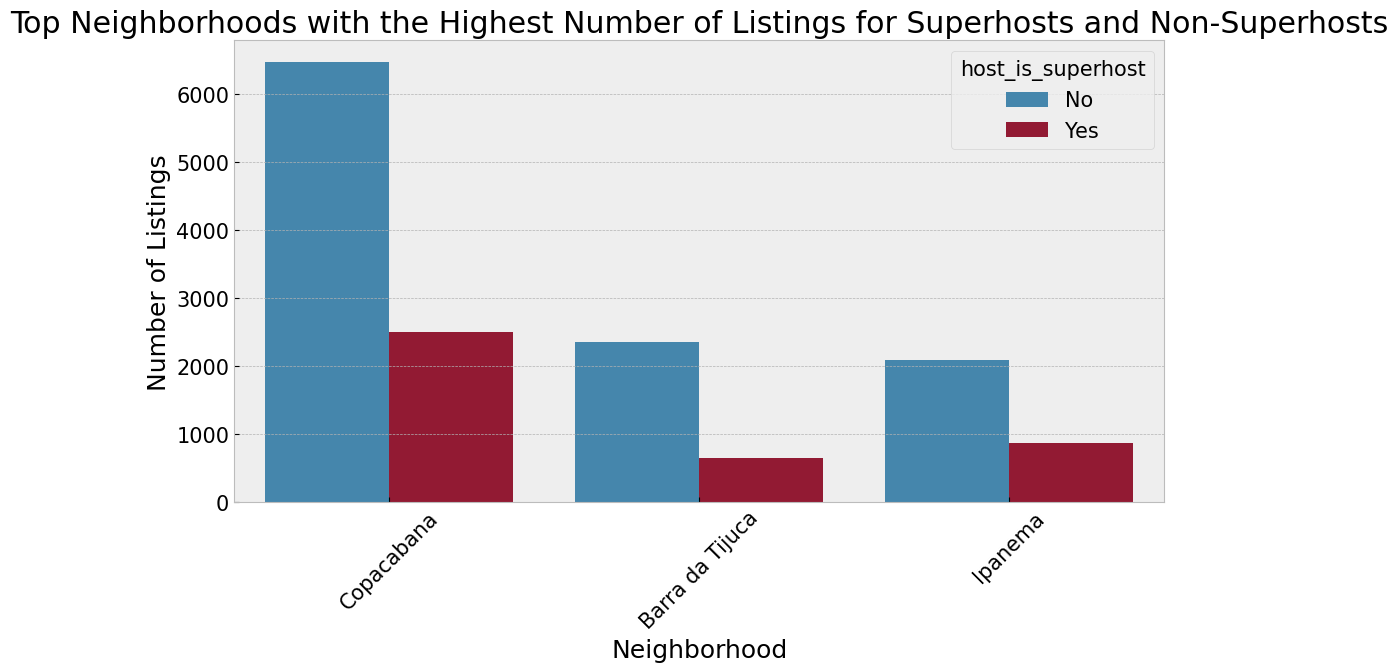

In [22]:
result = (
    listings.groupby(["host_is_superhost", "neighbourhood_cleansed"])
    .size()
    .reset_index(name="count")
)
top_neighborhoods = (
    result.groupby("host_is_superhost")
    .apply(lambda x: x.nlargest(3, "count"))
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_neighborhoods,
    x="neighbourhood_cleansed",
    y="count",
    hue=top_neighborhoods["host_is_superhost"].map(lambda x: "Yes" if x else "No"),
)

plt.title(
    "Top Neighborhoods with the Highest Number of Listings for Superhosts and Non-Superhosts"
)
plt.xlabel("Neighborhood")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)

plt.show()

# What's the Response Time?

## Response: Most superhost responds within an hour

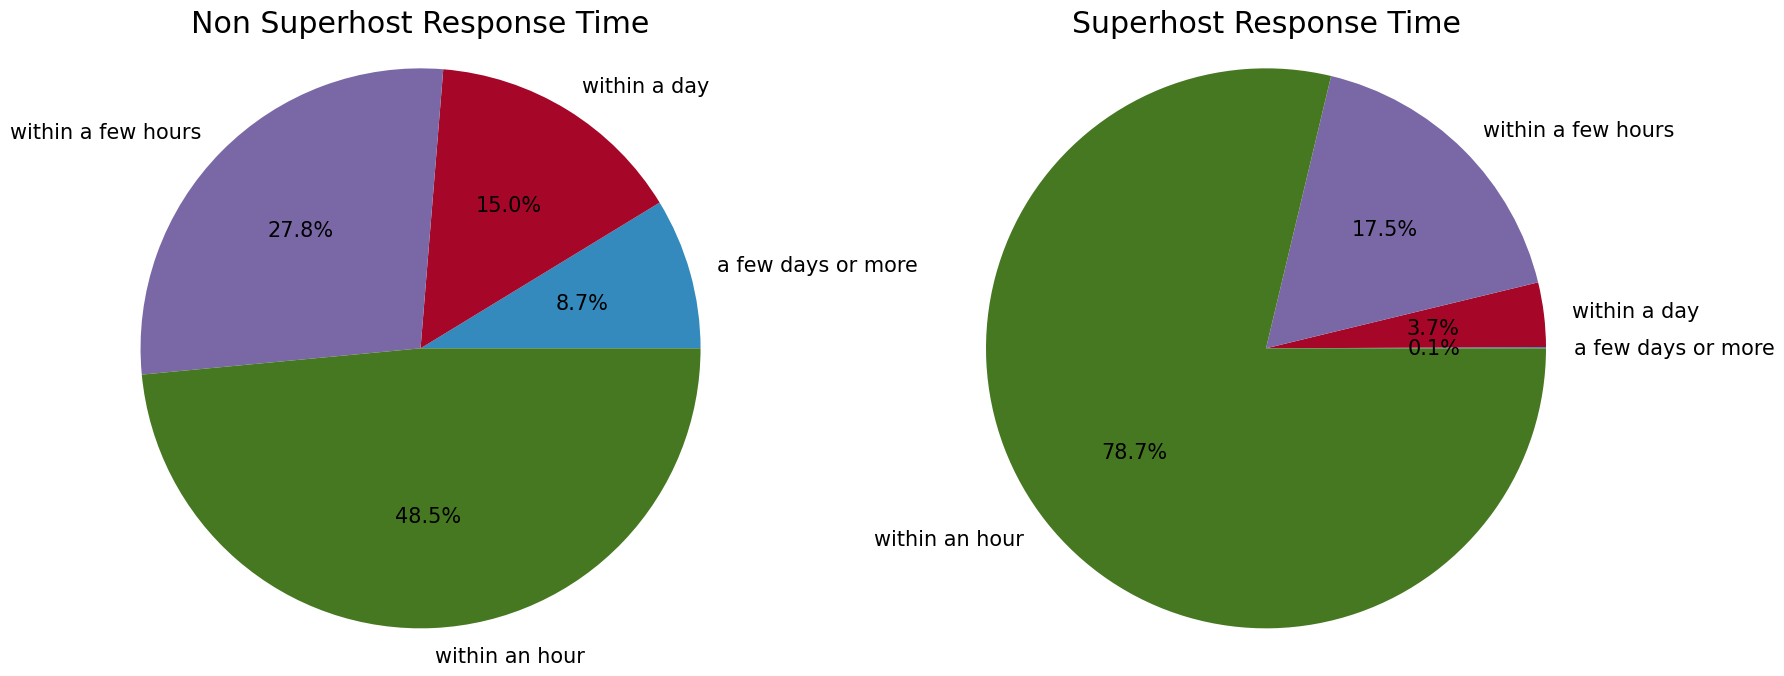

In [31]:
non_superhost = listings[listings["host_is_superhost"] == 0]
grouped_data_non_superhost = (
    non_superhost.groupby(["host_is_superhost", "host_response_time"])
    .size()
    .reset_index(name="count")
)
grouped_data_non_superhost["percentage"] = (
    grouped_data_non_superhost["count"]
    / grouped_data_non_superhost.groupby("host_is_superhost")["count"].transform("sum")
) * 100

superhost = listings[listings["host_is_superhost"] == 1]
grouped_data_superhost = (
    superhost.groupby(["host_is_superhost", "host_response_time"])
    .size()
    .reset_index(name="count")
)
grouped_data_superhost["percentage"] = (
    grouped_data_superhost["count"]
    / grouped_data_superhost.groupby("host_is_superhost")["count"].transform("sum")
) * 100


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Non Superhost pie chart
axes[0].pie(
    grouped_data_non_superhost["percentage"],
    labels=grouped_data_non_superhost["host_response_time"],
    autopct="%1.1f%%",
)
axes[0].axis("equal")
axes[0].set_title("Non Superhost Response Time")

# Superhost pie chart
axes[1].pie(
    grouped_data_superhost["percentage"],
    labels=grouped_data_superhost["host_response_time"],
    autopct="%1.1f%%",
)
axes[1].axis("equal")
axes[1].set_title("Superhost Response Time")

# Display the plot
plt.show()


# What's the Acceptance Rate?

## Response: The superhosts have a much higher acceptance rate.

In [100]:
listings.groupby(['host_is_superhost'])['host_acceptance_rate'].mean().reset_index()

,host_is_superhost,host_acceptance_rate
0,0.0,0.758016
1,1.0,0.921683
